# Linear Classifier - Softmax
All necessary imports at the beginning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata       
from sklearn.preprocessing import OneHotEncoder

## Load, explore and prepare dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a tranings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

In [2]:
mnist = fetch_mldata('MNIST original') #load MNIST
X, y = mnist["data"], mnist["target"] #separate images and labels

# shape of MNIST data
print('digits', X.shape)
print('labels',y.shape)

digits (70000, 784)
labels (70000,)


To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

label: 0.0


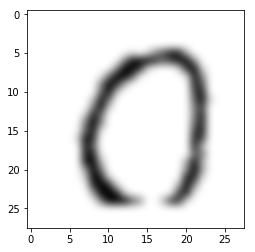

In [3]:
def plot_mnist_digit(digit):
    """
    plots a chosen digit

    :param digit: chosen digit
    :return: nothing
    """
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,60001)
print('label:',y[random_number]) 
plot_mnist_digit(X[random_number])

After a glimpse into MNIST let us explore it a bit further. The function plot_mnist_digits(data, examples_each_row) plots as many examples of each class as defined by 'examples_each_row'

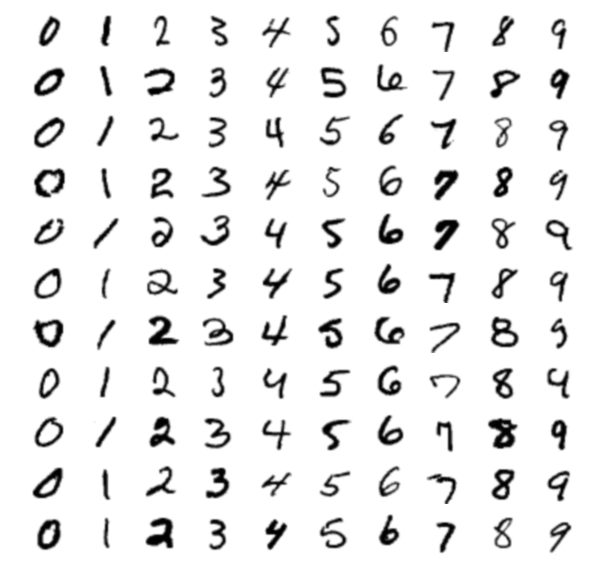

In [4]:
def plot_mnist_digits(data, examples_each_row):
    '''
    This code, inside the comment, shows us the firsts occurences (depends on how many are defined by the variable example_each_row)
    of each class/image. The code below selects the images randomly which is better for our use case, since we want to explore our
    dataset.
    
    fig, plot = plt.subplots(10, examples_each_row, figsize=(20, 20))
    for i in range(examples_each_row):
        j = 0
        for image, label in zip(X, y):
            if i == label:
                if j == 0:
                    plt.title(i)
                temp = image.reshape(28, 28)
                plot[i][j].imshow(temp, cmap='binary', interpolation='bicubic')
                j = j + 1
            if j == examples_each_row:
                break
                
    '''
    plt.figure(figsize=(10, 10))
    num_classes = 10

    for c in range(num_classes):
        # Select samples_per_class random keys of the labels == current class
        keys = np.random.choice(np.where(y == c)[0], examples_each_row)
        images = X[keys]

        for i in range(examples_each_row):
            f = plt.subplot(examples_each_row, num_classes,
                            i * num_classes + c + 1)
            f.axis('off')
            plt.imshow(
                images[i].reshape(28, 28),
                cmap='binary',
                interpolation='bicubic')


plot_mnist_digits(X, examples_each_row=11)
plt.show()

After exploring MNIST let us prepare the date for our linear classifier. First we need to separate traning and test data. Further we will shuffle the traning data to get a random distribution.  

In [5]:
# split data into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle training data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Define a linear classifier using Softmax

We will train a model to classify the MNIST dataset with the following equation:

$$ L = \frac{1}{M} \sum_{i=1}^{M} -log\; \left ( \frac{e^{h(x_j,\Theta)}}{\sum_{k=1}^{K}e^{h(x_k,\Theta)}} \right)_i + \frac{\lambda}{2} \sum_{}^{} \Theta^2, \: with \;\; h(X,\Theta) = X * \Theta $$

Using the universal equation for a loss function we can see the separate parts of that hugh equation.  

$$ L = \frac{1}{N} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on. Let us start with the score function or hypothesis:

$$h(X,\Theta) = X * \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)) so we can use the whole traning data $X$ instead of one digit $x_i$.

In [6]:
def class_scores(X, theta):
    '''
    this method returns the score values for each class of every digit 
    
    :param X: data - most of the time training data
    :param theta: learnable parameters theta 
    :returns: class score
    '''
    return np.dot(X, theta)

We assume the score values are unnormalized log probabilities and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$


In [7]:
def softmax(class_scores):
    """
    Calculate class probability distribution for each digit from given class scores
    
    :param class_scores: class scores of your function
    :return: probability distribution
    """
    return np.exp(class_scores) / np.sum(np.exp(class_scores),axis=1, keepdims=True)

The numerical range of the floating-point numbers used by Numpy is limited. For $float64$, the maximal representable number is on the order of $10^{308}$. Exponentiation in the softmax function makes it possible to easily overshoot this number, even for fairly modest-sized inputs.

A nice way to avoid this problem is by normalizing the inputs to be not too large or too small, by observing that we can use an arbitrary constant C by multiplying the fraction with.

$$  \frac{e^{ log(c)}}{e^{log(c)}} $$

So you get following function:

$$ P(Y=j\mid X=x_i) = \frac{e^{s_j + log(c)}}{\sum_{k=1}^{K}e^{s_k + log(c)}} $$

Where you can choose the actual value of $log(c)$ freely because let $log(c)=x$ then $x \in \mathbb{R}$ for all $c \in \mathbb{R}^+$ and $c \neq 0 $ .


In [8]:
def softmax(class_scores):
    """
    Calculate class probability distribution for each digit from given class scores.
    
    :param class_scores: class scores of your function
    :return: probability distribution
    """
    class_scores -= np.max(class_scores)
    return np.exp(class_scores) / np.sum(np.exp(class_scores),axis=1, keepdims=True)

After we can define the data loss funtion $L_i$.

$$ L_i = -log\;P(Y=j\mid X=x_i) $$

If the correct classes (labels) are in a [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) shape you can use a matrix multiplication to extract the correct class. 

In [9]:
def onehot_encode_label(label):
    """
    Support function to convert label vector into a one hot encoding matrix

    :param label: array with shape (D,) , D can be whatever you want
    :return: one hot encoding matrix
    """
    
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label


def data_loss(class_probabilities, onehot_encode_label):
    """
    Compute data_loss L_i for the correct class with a onehot encoded label
    
    :param class_probabilities: probabilities from the softmax function
    :param onehot_encode_label: correct labels in a one hot enconding shape
    
    :return: the data loss L_i
    """
    return onehot_encode_label * -np.log(class_probabilities)

Now we will calculate loss $L$ using the defined functions. 

$$ L = \frac{1}{M} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta)$$

Besides the loss L we will have to calculate the gradient for our loss function $L$. To minimize our loss we will need the gradient. Our gradient should look like

$$ {\displaystyle \operatorname {grad} (L)={\frac {\partial L}{\partial \theta_{1}}}{\hat {e}}_{1}+\cdots +{\frac {\partial L}{\partial \theta_{n}}}{\hat {e}}_{n}={\begin{pmatrix}{\frac {\partial L}{\partial \theta_{1}}}\\\vdots \\{\frac {\partial L}{\partial \theta_{n}}}\end{pmatrix}}.} $$

In [10]:
def loss(X, y, theta, lam):
    """
    :param X: data
    :param y: label of the data
    :param theta: learnable parameters
    :param lam: regularization factor
    
    :return: loss and gradient as a tupel
    """
    
    encoded_labels = onehot_encode_label(y)           # also needed for the gradient, therefore separated calculated
    probabilities = softmax(class_scores(X,theta))    # also needed for the gradient, therefore separated calculated
    loss_Li = data_loss(probabilities,encoded_labels) 
    
    m = X.shape[0]                                    # number of training data for normalization
    l2_regularization = (lam/2)*np.sum(theta*theta)   # regularization loss
  
    loss = np.sum(loss_Li)/m + l2_regularization
    
    dl2 = lam*theta
    dloss = np.dot(X.T, (probabilities - encoded_labels)/m)
    gradient = dloss +  dl2    
    
    return  loss, gradient

## Reduce the cost using gradient descent
Gradient descent is a way to minimize our Loss functions. It iteratively moves toward a set of parameter values that minimize our Loss function. This iterative minimization is achieved using calculus, taking steps in the negative direction of the  gradient (which is a vector that shows us the highest rise).

$$ {\displaystyle \mathbf {\theta} _{new}=\mathbf {\theta} _{old}-\gamma \times grad(L)} \space , \space \gamma = learning \space rate $$

$$ \Leftrightarrow {\displaystyle \mathbf {\theta} _{new}=\mathbf {\theta} _{old}-\gamma \space {\begin{pmatrix}{\frac {\partial L}{\partial \theta_{1}}}\\\vdots \\{\frac {\partial L}{\partial \theta_{n}}}\end{pmatrix}}.} $$

In [11]:
def gradient_descent(training_data, training_label, theta, lam=0.5, iterations=100, learning_rate=1e-5):
    losses = []

    for i in range(iterations):
        l, grad = loss(training_data, training_label, theta, lam)
        losses.append(l)
        theta -= learning_rate*grad
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(np.unique(y_train))])
# Start optimization with traning data, theta and optional hyperparameters
opt_model, loss_history = gradient_descent(X_train,y_train,theta,iterations=250)

## Stochastical gradient descent
In stoachstical gradient descent the gradient is computed with a few training examples or a minibatch as opposed to a single example. 

The reason for this is: 
first this reduces the variance in the parameter update and can lead to more stable convergence, 
second this allows the computation to take advantage of highly optimized matrix operations that should be used in a well vectorized computation of the cost and gradient. 

A typical minibatch size is 256, although the optimal size of the minibatch can vary for different applications and architectures.

In [12]:
def sgd(training_data, training_label, theta, lam=0.5, iterations=100, learning_rate=1e-5, batch_size=256):
    losses = []
    for i in range(iterations):
        shuffle_index = np.random.permutation(training_data.shape[0])
        data, label = training_data[shuffle_index], training_label[shuffle_index]
        data, label = data[:batch_size], label[:batch_size]
        
        l, grad = loss(data, label, theta, lam)
        losses.append(l)
        theta -= learning_rate*grad
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(np.unique(y_train))])
# Start optimization with traning data, theta and optional hyperparameters
opt_model_sgd, loss_history_sgd = sgd(X_train,y_train,theta,iterations=250)

## Evaluate model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during traning process. Further we can use the first loss value as a sanity check and we want to validate our implementation of the loss function works as intended. 

Recall loss value after first iteration should be $ log\:c$ with $c$ being number of classes. So our loss should be $ ln(10) $  which is equal to $log (10) $ because we have 10 different classes

### Evaluation gradient descent

In [13]:
print('last iteration loss:',loss_history[-1])
print('first iteration loss:',loss_history[0])
print('Is the first loss equal to ln(10)?', np.log(10) - loss_history[0] < 0.000001)

last iteration loss: 0.328714380441108
first iteration loss: 2.302585092994044
Is the first loss equal to ln(10)? True


Now to visulize the whole tranings process we can plot losss values from each iteration as a loss curve. 

Text(0.5,0,'iterations')

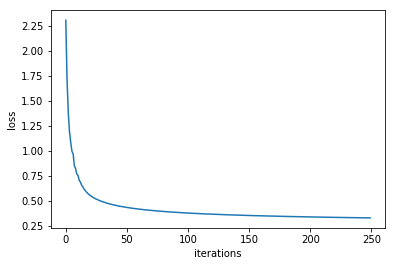

In [14]:
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')

In [15]:
print('last iteration loss:',loss_history_sgd[-1])
print('first iteration loss:',loss_history_sgd[0])
print('Is the first loss equal to ln(10)?', np.log(10) - loss_history_sgd[0] < 0.000001)

last iteration loss: 0.3893308953961286
first iteration loss: 2.3025850929940455
Is the first loss equal to ln(10)? True


Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [16]:
def modelAccuracy(X,y,theta):
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    accuracy = (sum(prediction == y))/X.shape[0]
    return accuracy

In [17]:
print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_model))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_model))

Training accuracy:  0.9093666666666667
Test accuracy:  0.9131


But that quantification is limited. A more gerenell approach is to calculate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and get different model measurements from it. A good overview for model measurements is provided by the wikipedia article of [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). We implement a confusion matrix for our model and calculate a [F1 score](https://en.wikipedia.org/wiki/F1_score) and ```print()``` it.

### Evaluation stochastical gradient descent

Text(0.5,0,'iterations')

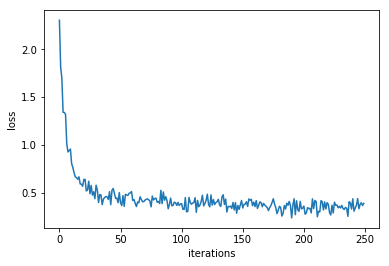

In [18]:
# Plot a loss curve
plt.plot(loss_history_sgd)
plt.ylabel('loss')
plt.xlabel('iterations')

In [19]:
print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_model_sgd))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_model_sgd))

Training accuracy:  0.9056333333333333
Test accuracy:  0.9116


# Confusion Matrix and F1 score 
The confusion Matrix $ m $ should look like ths


$$ \quad\quad (actual \space classes)\\
m = 
\begin{bmatrix}
 \space & 1 & 2 &  \cdot \cdot \cdot & \cdot \cdot \cdot & 8 & 9 
 \\ 1   & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot & \cdot \cdot \cdot  & \cdot \cdot \cdot   & \cdot \cdot \cdot 
 \\ 2  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  &\cdot \cdot \cdot  & \cdot \cdot \cdot   &  \cdot \cdot \cdot  
 \\  \cdot \cdot \cdot &   \cdot \cdot \cdot &   \cdot \cdot \cdot&  \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot
 \\ \cdot \cdot \cdot & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot
\\ 8  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot 
\\9  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot  & \cdot \cdot \cdot
 \end{bmatrix} \space (predicted \space classes) \space $$

with all correct predictions are located in the diagonal of the table, so it is easy to visually inspect the table for prediction errors, as they will be represented by values outside the diagonal.

To understand the confunsion matrix more lets look at $m_{example} 
$. $m_{example}$ predicted 100 times 1, 200 times 2 and 300 times 3 while the actuall class of the image was 1. It also predicted 200 times 1, 500 times 2 and 400 times 3 with 2 beeing the actuall class

$$ \quad\quad (actual \space classes)\\
m_{example} = 
\begin{bmatrix}
 \space & 1 & 2 &  \cdot \cdot \cdot \\ 1  & 100  & 200   & \cdot \cdot \cdot \\  2 & 200  & 500 &  \cdot \cdot \cdot  \\ 3  &300  & 400   &  \cdot \cdot \cdot  \\  \cdot \cdot \cdot &   \cdot \cdot \cdot &   \cdot \cdot \cdot&  \cdot \cdot \cdot \\
 \end{bmatrix} \space (predicted \space classes) \space $$

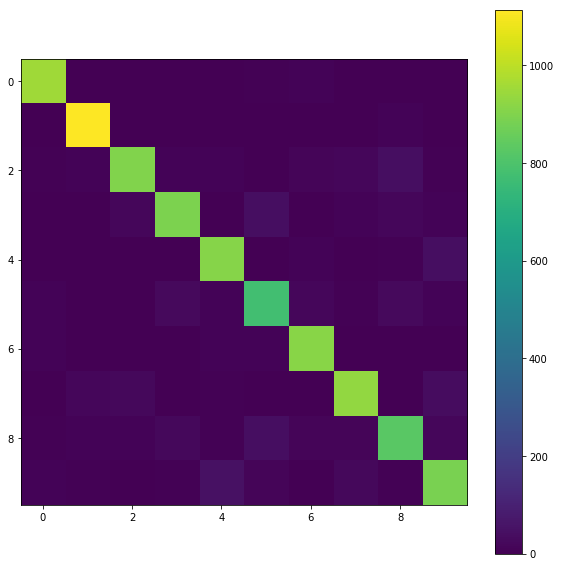

In [20]:
def confusionMatrix(X,y,theta):
    num_classes = 10
    probabilities = softmax(np.dot(X,theta))
    prediction = np.argmax(probabilities,axis=1)
    
    prediction = onehot_encode_label(prediction).tolist()
    y_encode = onehot_encode_label(y).tolist()
    
    matrix = np.zeros([num_classes, num_classes])
    for y, p in zip(y_encode, prediction):
        matrix[y.index(1)][p.index(1)] += 1
    return matrix

matrix = confusionMatrix(X_test,y_test,opt_model_sgd)
plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.colorbar()
plt.show()

After calculating the confusion matrix we can calculate the $F1$ score. Note that the $F1$ score is defined as

$$ F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}= \frac{2}{\frac{precision\space+\space recall}{precision \space \times \space  recall}} = \frac{2\times precision \times recall}{precision + recall}  $$ 

$$ \space recall = \frac{d}{c} , precision = \frac{d}{r}$$

With $d$ beeing all elements on the diagonal of the confusion Matrix, $r$ sum of every row of the confusion Matrix and $c$ sum of every collm of the confusion Matrix 

Note that the score will be calculated every time for each class which will result in an vector $scores$
$$ scores = \left(\begin{array}{c}F1_{1}\\ \cdot \\ \cdot \\ \cdot \\ \cdot \\F1_{9} \end{array}\right) $$

In [21]:
def f1Score(confMatrix):
    diag = [confMatrix[i][i] for i in range(10)] #all elemnts on the diagonal of the confMatrx
    colsum = np.sum(confMatrix, axis=0) #sum of every collum
    rowsum = np.sum(confMatrix, axis=1) #sum of every row
    
    recall = diag / colsum
    precision = diag / rowsum
    score = 2*recall*precision/(precision+recall) 
    return score

score = f1Score(matrix)
for i,j in enumerate(score):
    print("f1 score of", i, "is", j)

f1 score of 0 is 0.9637096774193548
f1 score of 1 is 0.9657266811279828
f1 score of 2 is 0.9000999000999
f1 score of 3 is 0.9012096774193548
f1 score of 4 is 0.9151180311401307
f1 score of 5 is 0.8696138780078344
f1 score of 6 is 0.9351710056151097
f1 score of 7 is 0.9114914425427872
f1 score of 8 is 0.8614583333333333
f1 score of 9 is 0.8788927335640138


# Visualize theta
One of the benefits of a simple model like softmax is that we can visualize the weights $theta$ for each of the classes, and see what it prefers. Here we look at one random weight of each class.

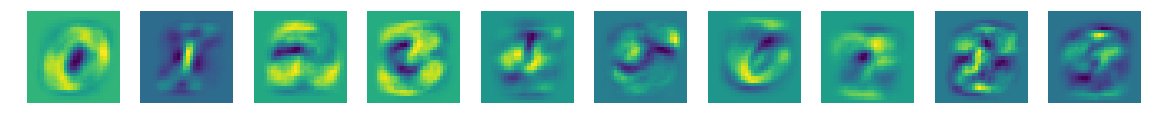

In [22]:
plt.figure(figsize=(20, 20))
num_classes = 10

for c in range(num_classes):
    f = plt.subplot(10, num_classes, 1 * num_classes + c + 1)
    f.axis('off')
    plt.imshow(np.reshape(opt_model[:,c],[28,28]))
plt.show()

# Predicting a own example

## Preparation
Before we start we need to import the pictures into our notebook. For that purpose we can use the ```imread()``` function from ```matplotlib.image```

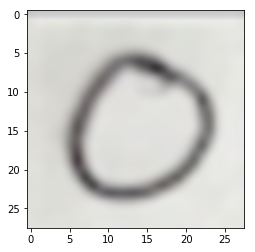

In [23]:
import matplotlib.image as mpimg

file = 'images/0.png'
temp = mpimg.imread(file)
plt.imshow(temp, cmap='binary', interpolation='bicubic')

## Creating a own batch
Since our function ```ìmread()``` works perfectly fine, we can create a whole matrix with all of our example. 

In [24]:
images = []
for i in range(10):
    file = 'images/' + str(i)+'.png'
    img = mpimg.imread(file)
    img = img[:,:,0] #removing 3rd dimension
    img = img.reshape(1,-1) 
    
    if len(images) == 0:
        images = img
    else:
        images = np.append(images,img, axis=0)
        
print(images.shape)
print(images.dtype)

(10, 784)
float32


Lets see whether we were successful by displaying all elements of our matrix

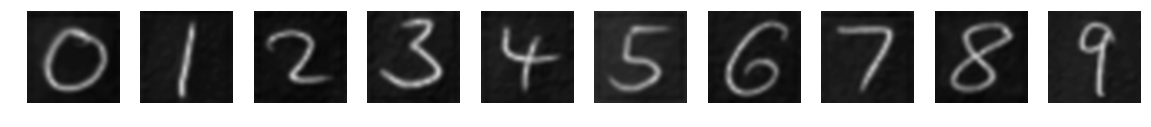

In [25]:
plt.figure(figsize=(20, 20))
num_classes = 10

for c in range(num_classes):
    f = plt.subplot(10, num_classes, 1 * num_classes + c + 1)
    f.axis('off')
    plt.imshow(np.reshape(images.T[:,c],[28,28]), cmap='binary', interpolation='bicubic')
plt.show()

### Evaluation

In [26]:
probabilities = softmax(np.dot(images,opt_model_sgd))
prediction = np.argmax(probabilities,axis=1)

for i,j in enumerate(prediction):
    print('Our model predicted:',i, 'as',j)

accuracy = (sum(prediction == np.array(range(10))))/10 * 100
print('Our accuracy was: ', accuracy,'%')

Our model predicted: 0 as 5
Our model predicted: 1 as 5
Our model predicted: 2 as 5
Our model predicted: 3 as 5
Our model predicted: 4 as 5
Our model predicted: 5 as 5
Our model predicted: 6 as 5
Our model predicted: 7 as 5
Our model predicted: 8 as 2
Our model predicted: 9 as 5
Our accuracy was:  10.0 %


## Normalize our images
We can see that our matrix $images$ has values inbetween 1 and 0 which could be a reason our model sees every picture as 5. So we are going to change that by normalizing every pixel of our image so that every value is inbetween 0 and 255

In [27]:
for i in range(images.shape[0]):
    for j in range(images[i].shape[0]):
        if images[i][j] <= 0.5:
            images[i][j] *= 255
        else:
            images[i][j] = 0

images = np.array(images, dtype=np.uint8)

### Evaluation

In [28]:
probabilities = softmax(np.dot(images,opt_model_sgd))
prediction = np.argmax(probabilities,axis=1)

for i,j in enumerate(prediction):
    print('Our model predicted:',i, 'as',j)

accuracy = (sum(prediction == np.array(range(10))))/10 * 100
print('Our accuracy was: ', accuracy,'%')

Our model predicted: 0 as 0
Our model predicted: 1 as 1
Our model predicted: 2 as 2
Our model predicted: 3 as 3
Our model predicted: 4 as 4
Our model predicted: 5 as 5
Our model predicted: 6 as 5
Our model predicted: 7 as 2
Our model predicted: 8 as 5
Our model predicted: 9 as 7
Our accuracy was:  60.0 %
